In [61]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d
import h5py
import json
import os
from scipy import signal as sig
from scipy.interpolate import interp1d

# Specify location of data
folder = 'LOSC_Event_tutorial/'
plt.style.use('seaborn-muted')

In [2]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl

def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

# Import Data

In [3]:
file_names = os.listdir(folder)

# Save events from Hanford, Livingston and corresponding GW template
L_events = []
H_events = []
for file in file_names: 
    if file[0] == 'H':
        H_events.append(file)
        for j in file_names: 
            if j[:] == 'L-L1_LOSC_4' + file[11:]:
                L_events.append(j)

# Save GW templates manually, making sure it corresponds to correct event
GW = ['GW170104_4_template.hdf5','GW151226_4_template.hdf5','LVT151012_4_template.hdf5','GW150914_4_template.hdf5']

In [4]:
print('''
Handford Events:
-----------------
{0}

Livinston Events:
-----------------
{1}

GW Templates:
-----------------
{2}
'''.format(H_events, L_events, GW))


Handford Events:
-----------------
['H-H1_LOSC_4_V1-1167559920-32.hdf5', 'H-H1_LOSC_4_V2-1135136334-32.hdf5', 'H-H1_LOSC_4_V2-1128678884-32.hdf5', 'H-H1_LOSC_4_V2-1126259446-32.hdf5']

Livinston Events:
-----------------
['L-L1_LOSC_4_V1-1167559920-32.hdf5', 'L-L1_LOSC_4_V2-1135136334-32.hdf5', 'L-L1_LOSC_4_V2-1128678884-32.hdf5', 'L-L1_LOSC_4_V2-1126259446-32.hdf5']

GW Templates:
-----------------
['GW170104_4_template.hdf5', 'GW151226_4_template.hdf5', 'LVT151012_4_template.hdf5', 'GW150914_4_template.hdf5']



# PART A: ESTIMATING NOISE MODEL

To estimate the noise model, I'm going to average the PSD over all the events to average out the signal (and since the system noise is time invariant). I'll also make sure to window the data using the Tukey model, which is flat in the center where the signal is most likely to be. 

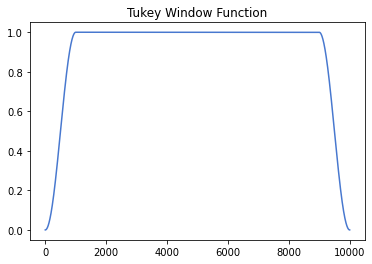

In [62]:
# To get an idea of the window function I am going to use, I've plotted an example below. 
tukey_window = sig.windows.tukey(10000, alpha=0.2)
plt.plot(tukey_window)
plt.title('Tukey Window Function')
plt.show()

In [63]:
def get_noise_model(events):
    
    PSD = 0
    for i in events:
        strain, dt, utc = read_file(folder + i)
        N = len(strain)
        
        # Window the function
        window = sig.windows.tukey(N, alpha = 0.2)
        
        # Get PSD
        psd = np.abs(np.fft.rfft(strain*window))**2
        PSD+=psd
    
    # Average
    noise_model = PSD/len(events)
    
    return noise_model

# Get the noise model for each of the detectors
raw_noise_model_H = get_noise_model(H_events)
raw_noise_model_L = get_noise_model(L_events)

In [64]:
# Smooth the noise models
def smooth_data(noise, n_smooth):
    smoothed = np.convolve(noise, np.ones(n_smooth)/n_smooth, mode = 'same')
    return smoothed

smooth_noise_H = smooth_data(raw_noise_model_H, 100)
smooth_noise_L = smooth_data(raw_noise_model_L, 100)

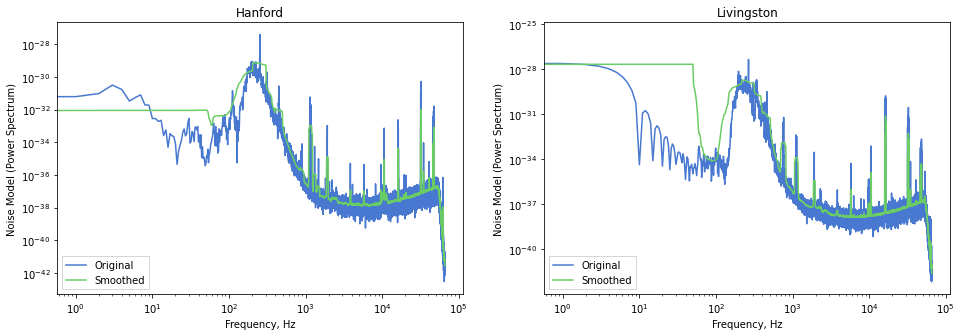

In [65]:
# Plot raw vs smoothed noise models

# Plot
fig, axs = plt.subplots(1,2, figsize = (16,5))
axs[0].loglog((raw_noise_model_H), label = 'Original')
axs[0].loglog(smooth_noise_H,label = 'Smoothed')
axs[0].set_title('Hanford')
leg0 = axs[0].legend(loc="lower left",
                 ncol=1, shadow=False, fancybox=False)

axs[1].loglog(raw_noise_model_L, label = 'Original')
axs[1].loglog(smooth_noise_L,label = 'Smoothed')
axs[1].set_title('Livingston')
leg1 = axs[1].legend(loc="lower left",
                 ncol=1, shadow=False, fancybox=False)


for ax in axs.flat:
    ax.set(xlabel = 'Frequency, Hz', ylabel='Noise Model (Power Spectrum)')

Some additional notes on the above:
- I've smoothed out the noise model: however, I have not removed the big spikes since they are intrinsic to the actual noise. I have, however, removed small scale oscilations that were most likely just white noise. 
- The data we care about lies in the range of ~20 Hz to ~2000 Hz (according to LIGO). Consequently, it doesn't matter that the noise model for frequencies lower than this don't follow the data that closely. 

# PART B: MATCHED FILTERS

### Whitening the data

Using the noise model, we can now whiten our data and look for the signal. 

In [75]:
def whiten(signal, noise_model, fs = 4096):
    
    # Start by getting the tukey window
    N = len(signal)
    window = sig.windows.tukey(N, alpha = 0.2)
    
    # Get spectrum of windowed data
    spectr = np.fft.rfft(signal*window)
    
    # Get frequencies
    dt = 1/fs
    freq = np.fft.rfftfreq(N, dt)
    
    # Whiten by dividing by noise model in fourier space
    whitened_ft = spectr / np.sqrt(noise_model)
    
    return whitened_ft, freq

def xcorr(strain, template, noise_model):
    
    N = len(strain)
    
    # Get whitened data in Fourier space
    strain_ft_whitened, freq = whiten(strain, noise_model)
    template_ft_whitened, freq = whiten(template, noise_model)
    
    # Get matched filter
    xcorr = np.fft.irfft(strain_ft_whitened*np.conj(template_ft_whitened))
    
    return xcorr, freq

EVENT: 1
_____________


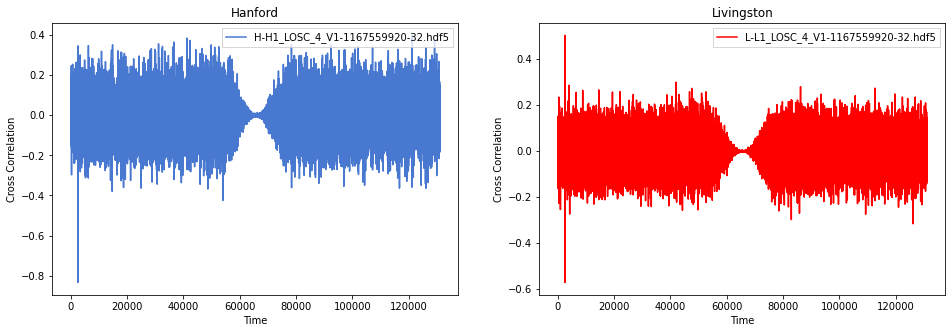

EVENT: 2
_____________


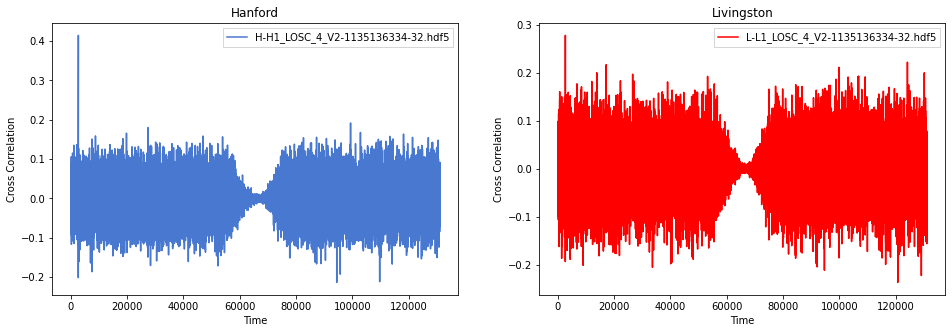

EVENT: 3
_____________


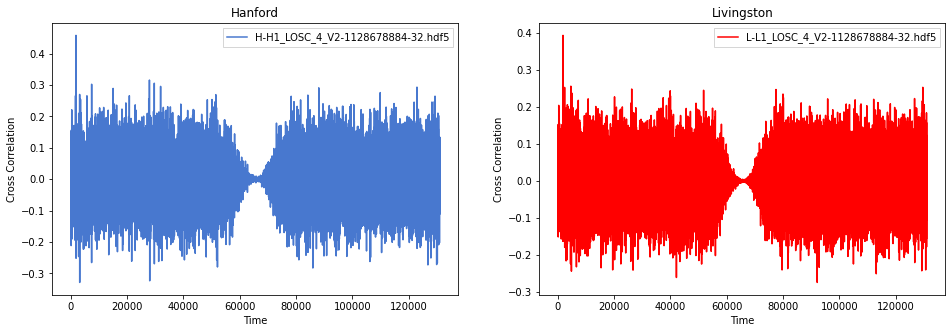

EVENT: 4
_____________


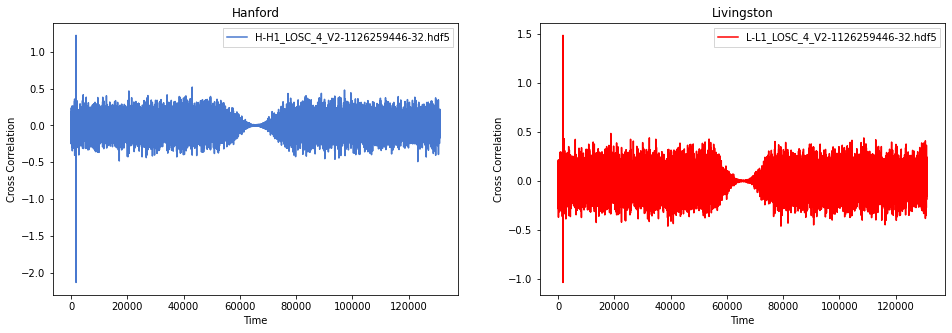

In [98]:
# Let's see how we did! 
xcorrs_H = np.empty([4,131072])
xcorrs_L = np.empty([4,131072])

for i in range(4):
    # Load in each event
    H_i, dt, utc = read_file(folder + H_events[i])
    L_i, dt, utc = read_file(folder + L_events[i])
    th_i, tl_i = read_template(folder + GW[i])
    
    # Get xcorr for each event
    xcorr_H_i, freq = xcorr(H_i, th_i, smooth_noise_H)
    xcorr_L_i, freq = xcorr(L_i, tl_i, smooth_noise_L)
    
    # Save data for analysis later
    xcorrs_H[i,:] = xcorr_H_i
    xcorrs_L[i,:] = xcorr_L_i
    
    
    N = len(xcorr_H_i)
    
    # Plot 
    print('EVENT: {0}'.format(i+1))
    print('_____________')
    fig, axs = plt.subplots(1,2, figsize = (16,5))
    axs[0].plot(xcorr_H_i, label = H_events[i])
    axs[0].set_title('Hanford')
    leg0 = axs[0].legend(loc = 'upper right', ncol=1, shadow=False, fancybox=False)
    
    axs[1].plot(xcorr_L_i, label = L_events[i], color = 'red')
    axs[1].set_title('Livingston')
    leg1 = axs[1].legend(loc = 'upper right', ncol=1, shadow=False, fancybox=False)
    
    for ax in axs.flat:
        ax.set(xlabel = 'Time', ylabel= 'Cross Correlation')
    
    plt.show()


# PART C: SIGNAL TO NOISE

In this section, we estimate the signal-to-noise ratio of the detection. 

We can estimate the noise by evaluating the standard deviation of the signal in an area that isn't affected by the window nor where a strong detection is. In all of the plots, a reasonable spot where the noise looks random is around 20000 - 40000 on the 'time' axis. 

In [112]:
# Get noise of each event by estimating it from 20000-40000
noise_H_events = np.abs(np.std(xcorrs_H[:,20000:40000], axis = 1))
noise_L_events = np.abs(np.std(xcorrs_L[:,20000:40000], axis = 1))

# Get max value of xcorr
max_H = np.max(np.abs(xcorrs_H), axis = 1)
max_L = np.max(np.abs(xcorrs_L), axis = 1)

# Get SNR of each event
SNR_H = max_H/noise_H_events
SNR_L = max_L/noise_L_events

# Combined SNR 
# TO DO #

for i in range(4):
    print('EVENT: {0}'.format(i+1))
    print('_____________')
    print()
    print('Noise Estimate Hanford: ', noise_H_events[i])
    print('SNR: ',SNR_H[i])
    print('\nNoise Estimate Livingston: ', noise_L_events[i])
    print("SNR: ", SNR_L[i])
    print('\n')
    

EVENT: 1
_____________

Noise Estimate Hanford:  0.1016061339814134
SNR:  8.203710230839055

Noise Estimate Livingston:  0.0714070434021454
SNR:  7.993204260766125


EVENT: 2
_____________

Noise Estimate Hanford:  0.045800555353317125
SNR:  9.051324090768135

Noise Estimate Livingston:  0.05281168792550174
SNR:  5.255315593485582


EVENT: 3
_____________

Noise Estimate Hanford:  0.07792187136133012
SNR:  5.875851808424641

Noise Estimate Livingston:  0.06736063200339283
SNR:  5.833258941999893


EVENT: 4
_____________

Noise Estimate Hanford:  0.1257456236345201
SNR:  16.969271337798222

Noise Estimate Livingston:  0.12058483248253338
SNR:  12.347227455493671


